In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/blais.ch/Documents/_01_code/RMG_env_1/RMG-Py/')
import os
import shutil
import sys
import itertools

from rmgpy.chemkin import load_chemkin_file
from rmgpy.data.surface import MetalPropertyLibrary, SitePropertyLibrary, MetalPropertyDatabase, SitePropertyDatabase
from rmgpy.data.thermo import ThermoDatabase

In [2]:
mpdb = MetalPropertyDatabase()
spdb = SitePropertyDatabase()
path = '/Users/blais.ch/Documents/_01_code/RMG_env_1/RMG-database/input/surface/'
mpdb.load(path)
spdb.load(path)

In [3]:
coords_111 = spdb.get_all_coordination_numbers_on_facet('111')
coords_100 = spdb.get_all_coordination_numbers_on_facet('100')
coords_211 = spdb.get_all_coordination_numbers_on_facet('211')
coords_553 = spdb.get_all_coordination_numbers_on_facet('553')

coord_num_dict = {}
coord_num_dict['111'] = coords_111["111_hcp_hollow"]
coord_num_dict['100'] = coords_100["100_hollow"]
coord_num_dict['211'] = coords_553["553_111_edge_top"]


In [4]:
coords_553

{'553_111_edge_bridge': 5.44, '553_111_edge_top': 5.5}

In [5]:
# read in the data from gao
gao_file = "/Users/blais.ch/Documents/_01_code/05_Project_repos_Github/thesis_work/gao_data/gao_calcs.xlsx"
df_parity_c = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="", skiprows=1, nrows=12)
df_parity_co = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="W,X,Y", skiprows=1, nrows=20)
df_parity_co

,Surfaces.4,DFTcal.4,predicted.4
0,Cu(111),-0.54112,-0.625232
1,Rh(111),-1.74536,-1.751547
2,Pd(111),-1.76085,-1.354418
3,Ag(111),-0.00516,0.311308
4,Pt(111),-1.53945,-1.418214
5,Au(111),-0.04466,-0.135714
6,Ni(211),-1.71206,-1.318359
7,Cu(211),-0.67452,-0.865232
8,Rh(211),-1.92374,-1.991547
9,Pd(211),-1.80986,-1.594418


## $\Delta E_{ad} = 0.1*\frac{X_{m}-X}{X_{m}+1}*\psi+0.2*\frac{X+1}{X_{m}+1}*\overline{CN}+\theta$

In [6]:
df = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="AB:AD", skiprows=1, nrows=21)
df

,Surfaces.5,DFTcal.5,predicted.5
0,Ni(111),-0.58631,-0.547487
1,Cu(111),-0.08917,-0.241626
2,Rh(111),-0.96404,-1.001889
3,Pd(111),-0.52505,-0.733827
4,Ag(111),0.21431,0.390538
5,Pt(111),-0.76340,-0.776889
6,Au(111),0.09856,0.088798
7,Ni(211),-1.16539,-0.841487
8,Cu(211),-0.54614,-0.535626
9,Rh(211),-1.42703,-1.295889


In [7]:
coord_num_dict = {}
coord_num_dict['111'] = coords_111["111_hcp_hollow"]
coord_num_dict['100'] = coords_100["100_hollow"]
coord_num_dict['211'] = coords_553["553_111_edge_top"]

In [8]:
coord_num_dict[r'PtM111'] = 2.5
coord_num_dict['PtM111']

2.5

In [32]:
def ret_fac(x):
    return coord_num_dict[x]


def ret_metal(x):
    return mpdb.get_psi(x)

psi

def get_alpha(X, Xm, Xp, Xpm):
    alphap=Xp/(Xpm+1)
    alpha = (Xm-X)/(Xm+1)
    alphall = alpha - alphap
    print("alpha", alphall)
    return alphall

def get_bes(df, bo_dict, alpha=None):
    """
    try to replicate the results from Gao et al. 2017 
    """
    coord_num_dict = {}
    coord_num_dict['111'] = coords_111["111_hcp_hollow"]
    coord_num_dict['100'] = coords_100["100_hollow"]
    coord_num_dict['211'] = coords_553["553_111_edge_top"]
    coord_num_dict[r'PtM111'] = 2.5

    if alpha is not None:
        alphaagg = alpha
    else:
        alphaagg = get_alpha(bo_dict['X'], bo_dict['Xm'], bo_dict['Xp'], bo_dict['Xpm'])

    for col in df.columns: 
        if "Surfaces" in col:
            df.rename(columns={col: "Surfaces"}, inplace=True)
        if "DFT" in col:
            df.rename(columns={col: "DFTcal"}, inplace=True)
        if "predicted" in col:
            df.rename(columns={col: "predicted"}, inplace=True)


    df["metal"] = df["Surfaces"].str.split("(",expand=True)[0]
    df["facet"] = df["Surfaces"].str.split("(",expand=True)[1].str.split(")",expand=True)[0]

    df['cn'] = df['facet'].apply(lambda x: ret_fac(x))
    df['psi'] = df['metal'].apply(lambda x: ret_metal(x))

    df['theta'] = df['DFTcal'] - (0.1*alphaagg*df['psi']+0.2*(1-alphaagg)*df['cn'])

    

    au_theta = df[df['metal'].isin(['Au'])]['theta'].mean()

    df['mycalc'] = 0.1*alphaagg*df['psi']+0.2*(1-alphaagg)*df['cn'] + au_theta

    df['sq_err_me'] = (df['DFTcal'] - df['mycalc'])**2
    df['sq_err_gao'] = (df['DFTcal'] - df['predicted'])**2

    # n_bes = df.shape[0]
    # rmse_me = df['sq_err_me'].sum()/n_bes

    print("MSE ME", df['sq_err_me'].mean())
    print("MSE Gao", df['sq_err_gao'].mean())

    return df

In [73]:
# XC : "AB:AD"
df_xc = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="C:E", skiprows=1, nrows=21)
bo_xc = {'X':0, 'Xm':4, 'Xp': 0, 'Xpm': 0}

get_bes(df_xc, bo_xc)

alpha 0.8
MSE ME 0.24175217911128005
MSE Gao 0.24409108892428386


,Surfaces,DFTcal,predicted,metal,facet,cn,psi,theta,mycalc,sq_err_me,sq_err_gao
0,Ni(111),-0.529710,-0.104018,Ni,111,7.50,52.36,-5.018510,-0.10294,0.182133,0.181213
1,Cu(111),1.532100,0.802237,Cu,111,7.50,63.68,-3.862300,0.80266,0.532083,0.532700
2,Rh(111),-1.233370,-1.450394,Rh,111,7.50,35.53,-4.375770,-1.44934,0.046643,0.047100
3,Pd(111),-0.488510,-0.656136,Pd,111,7.50,45.45,-4.424510,-0.65574,0.027966,0.028098
4,Ag(111),2.700000,2.675317,Ag,111,7.50,87.10,-4.568000,2.67626,0.000564,0.000609
5,Pt(111),-0.774100,-0.783728,Pt,111,7.50,43.86,-4.582900,-0.78294,0.000078,0.000093
6,Au(111),1.825870,1.781272,Au,111,7.50,75.92,-4.547730,1.78186,0.001937,0.001989
7,Ni(211),-1.473330,-0.184018,Ni,211,5.50,52.36,-5.882130,-0.18294,1.665106,1.662324
8,Cu(211),0.642370,0.722237,Cu,211,5.50,63.68,-4.672030,0.72266,0.006446,0.006379
9,Rh(211),-1.536270,-1.530394,Rh,211,5.50,35.53,-4.598670,-1.52934,0.000048,0.000035


In [74]:
# XCH : H:J
df_xch = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="H:J", skiprows=1, nrows=21)
bo_xch = {'X':1, 'Xm':4, 'Xp': 0, 'Xpm': 0}
get_bes(df_xch, bo_xch)

alpha 0.6
MSE ME 0.08294986517604204
MSE Gao 0.08167013852365924


,Surfaces,DFTcal,predicted,metal,facet,cn,psi,theta,mycalc,sq_err_me,sq_err_gao
0,Ni(111),-1.477220,-0.883639,Ni,111,7.50,52.36,-5.218820,-0.882053,0.354223,0.352339
1,Cu(111),0.056810,-0.203947,Cu,111,7.50,63.68,-4.363990,-0.202853,0.067425,0.067994
2,Rh(111),-1.973760,-1.893421,Rh,111,7.50,35.53,-4.705560,-1.891853,0.006709,0.006454
3,Pd(111),-1.356110,-1.297727,Pd,111,7.50,45.45,-4.683110,-1.296653,0.003535,0.003409
4,Ag(111),1.154840,1.200863,Ag,111,7.50,87.10,-4.671160,1.202347,0.002257,0.002118
5,Pt(111),-1.824390,-1.393421,Pt,111,7.50,43.86,-5.055990,-1.392053,0.186915,0.185734
6,Au(111),0.436270,0.530329,Au,111,7.50,75.92,-4.718930,0.531547,0.009078,0.008847
7,Ni(211),-1.731460,-1.043639,Ni,211,5.50,52.36,-5.313060,-1.042053,0.475282,0.473098
8,Cu(211),-0.339250,-0.363947,Cu,211,5.50,63.68,-4.600050,-0.362853,0.000557,0.000610
9,Rh(211),-1.929730,-2.053421,Rh,211,5.50,35.53,-4.501530,-2.051853,0.014914,0.015299


In [75]:
# XCH2: M:O
df_xch2 = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="M:O", skiprows=1, nrows=22)
bo_xch2 = {'X':2, 'Xm':4, 'Xp': 0, 'Xpm': 0}
get_bes(df_xch2, bo_xch2)

alpha 0.4
MSE ME 0.05335151398375824
MSE Gao 0.053473627493202884


,Surfaces,DFTcal,predicted,metal,facet,cn,psi,theta,mycalc,sq_err_me,sq_err_gao
0,Ni(111),-1.532330,-1.378259,Ni,111,7.50,52.36,-4.526730,-1.376143,0.024394,0.023738
1,Cu(111),-0.594110,-0.925132,Cu,111,7.50,63.68,-4.041310,-0.923343,0.108395,0.109575
2,Rh(111),-1.795030,-2.051447,Rh,111,7.50,35.53,-4.116230,-2.049343,0.064675,0.065750
3,Pd(111),-1.362010,-1.654318,Pd,111,7.50,45.45,-4.080010,-1.652543,0.084410,0.085444
4,Ag(111),0.156470,0.011408,Ag,111,7.50,87.10,-4.227530,0.013457,0.020453,0.021043
5,Pt(111),-1.659350,-1.718114,Pt,111,7.50,43.86,-4.313750,-1.716143,0.003225,0.003453
6,Au(111),-0.233260,-0.435614,Au,111,7.50,75.92,-4.170060,-0.433743,0.040194,0.040947
7,Ni(211),-1.760060,-1.618259,Ni,211,5.50,52.36,-4.514460,-1.616143,0.020712,0.020107
8,Cu(211),-0.852390,-1.165132,Cu,211,5.50,63.68,-4.059590,-1.163343,0.096692,0.097807
9,Rh(211),-1.988350,-2.291447,Rh,211,5.50,35.53,-4.069550,-2.289343,0.090597,0.091868


In [76]:
# XCH3: R:T
df_xch3 = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="R:T", skiprows=1, nrows=22)
bo_xch3 = {'X':3, 'Xm':4, 'Xp': 0, 'Xpm': 0}
get_bes(df_xch3, bo_xch3)

alpha 0.2
MSE ME 0.02352152116001637
MSE Gao 0.022877107972718306


,Surfaces,DFTcal,predicted,metal,facet,cn,psi,theta,mycalc,sq_err_me,sq_err_gao
0,Ni(111),-2.109800,-2.036680,Ni,111,7.50,52.36,-4.357000,-2.03401,0.005744,0.005347
1,Cu(111),-1.630210,-1.810116,Cu,111,7.50,63.68,-4.103810,-1.80761,0.031471,0.032366
2,Rh(111),-2.122510,-2.373274,Rh,111,7.50,35.53,-4.033110,-2.37061,0.061554,0.062882
3,Pd(111),-2.033590,-2.174709,Pd,111,7.50,45.45,-4.142590,-2.17221,0.019216,0.019915
4,Ag(111),-1.340420,-1.341846,Ag,111,7.50,87.10,-4.282420,-1.33921,0.000001,0.000002
5,Pt(111),-2.313800,-2.206607,Pt,111,7.50,43.86,-4.391000,-2.20401,0.012054,0.011490
6,Au(111),-1.600210,-1.565357,Au,111,7.50,75.92,-4.318610,-1.56281,0.001399,0.001215
7,Ni(211),-2.492040,-2.356680,Ni,211,5.50,52.36,-4.419240,-2.35401,0.019052,0.018322
8,Cu(211),-2.000000,-2.130116,Cu,211,5.50,63.68,-4.153600,-2.12761,0.016284,0.016930
9,Rh(211),-2.537720,-2.693274,Rh,211,5.50,35.53,-4.128320,-2.69061,0.023375,0.024197


In [172]:
# XCO: W:Y
df_xco = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="W:Y", skiprows=1, nrows=20)
bo_xco = {'X':2, 'Xm':4, 'Xp': 0, 'Xpm': 0}
get_bes(df_xco, bo_xco)

alpha 0.4
MSE ME 0.06008807647777757
MSE Gao 0.06022184100200798


,Surfaces,DFTcal,predicted,metal,facet,cn,psi,theta,mycalc,sq_err_me,sq_err_gao
0,Cu(111),-0.54112,-0.625232,Cu,111,7.50,63.68,-3.98832,-0.623467,0.006781,0.007075
1,Rh(111),-1.74536,-1.751547,Rh,111,7.50,35.53,-4.06656,-1.749467,0.000017,0.000038
2,Pd(111),-1.76085,-1.354418,Pd,111,7.50,45.45,-4.47885,-1.352667,0.166614,0.165187
3,Ag(111),-0.00516,0.311308,Ag,111,7.50,87.10,-4.38916,0.313333,0.101438,0.100152
4,Pt(111),-1.53945,-1.418214,Pt,111,7.50,43.86,-4.19385,-1.416267,0.015174,0.014698
5,Au(111),-0.04466,-0.135714,Au,111,7.50,75.92,-3.98146,-0.133867,0.007958,0.008291
6,Ni(211),-1.71206,-1.318359,Ni,211,5.50,52.36,-4.46646,-1.316267,0.156652,0.155000
7,Cu(211),-0.67452,-0.865232,Cu,211,5.50,63.68,-3.88172,-0.863467,0.035701,0.036371
8,Rh(211),-1.92374,-1.991547,Rh,211,5.50,35.53,-4.00494,-1.989467,0.004320,0.004598
9,Pd(211),-1.80986,-1.594418,Pd,211,5.50,45.45,-4.28786,-1.592667,0.047173,0.046415


In [85]:
# XCOOH : "AB:AD"
df_xhooh = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="AB:AD", skiprows=1, nrows=21)
bo_xcooh = {'X':1, 'Xm':5, 'Xp': 2, 'Xpm': 4} # this is intuitively wrong, but it is what is in the data
get_bes(df_xhooh, bo_xcooh)


alpha 0.2666666666666666
MSE ME 0.02934183079470897
MSE Gao 0.028982666405399045


,Surfaces,DFTcal,predicted,metal,facet,cn,psi,theta,mycalc,sq_err_me,sq_err_gao
0,Ni(111),-0.58631,-0.547487,Ni,111,7.50,52.36,-3.082577,-0.537490,2.383392e-03,0.001507
1,Cu(111),-0.08917,-0.241626,Cu,111,7.50,63.68,-2.887303,-0.235623,2.144858e-02,0.023243
2,Rh(111),-0.96404,-1.001889,Rh,111,7.50,35.53,-3.011507,-0.986290,4.950625e-04,0.001433
3,Pd(111),-0.52505,-0.733827,Pd,111,7.50,45.45,-2.837050,-0.721757,3.869351e-02,0.043588
4,Ag(111),0.21431,0.390538,Ag,111,7.50,87.10,-3.208357,0.388910,3.048516e-02,0.031056
5,Pt(111),-0.76340,-0.776889,Pt,111,7.50,43.86,-3.033000,-0.764157,5.725444e-07,0.000182
6,Au(111),0.09856,0.088798,Au,111,7.50,75.92,-3.025973,0.090777,6.058028e-05,0.000095
7,Ni(211),-1.16539,-0.841487,Ni,211,5.50,52.36,-3.368323,-0.830823,1.119349e-01,0.104913
8,Cu(211),-0.54614,-0.535626,Cu,211,5.50,63.68,-3.050940,-0.528957,2.952669e-04,0.000111
9,Rh(211),-1.42703,-1.295889,Rh,211,5.50,35.53,-3.181163,-1.279623,2.172873e-02,0.017198


In [111]:
# XCHO : "AG:AI"
df_xcho = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="AG:AI", skiprows=1, nrows=21)
bo_xcho = {'X':2, 'Xm':5, 'Xp': 1, 'Xpm': 4}
get_bes(df_xcho, bo_xcho)


alpha 0.3
MSE ME 0.05289235908571429
MSE Gao 0.05322264575837855


,Surfaces,DFTcal,predicted,metal,facet,cn,psi,theta,mycalc,sq_err_me,sq_err_gao
0,Ni(111),-0.69310,-0.695319,Ni,111,7.50,52.36,-3.31390,-0.69294,2.560000e-08,0.000005
1,Cu(111),0.12373,-0.355474,Cu,111,7.50,63.68,-2.83667,-0.35334,2.275958e-01,0.229636
2,Rh(111),-1.12059,-1.200210,Rh,111,7.50,35.53,-3.23649,-1.19784,5.967562e-03,0.006339
3,Pd(111),-0.77845,-0.902363,Pd,111,7.50,45.45,-3.19195,-0.90024,1.483280e-02,0.015355
4,Ag(111),0.36719,0.346931,Ag,111,7.50,87.10,-3.29581,0.34926,3.214849e-04,0.000410
5,Pt(111),-1.05376,-0.950210,Pt,111,7.50,43.86,-3.41956,-0.94794,1.119787e-02,0.010722
6,Au(111),0.00678,0.011665,Au,111,7.50,75.92,-3.32082,0.01386,5.012640e-05,0.000024
7,Ni(211),-1.13899,-0.975319,Ni,211,5.50,52.36,-3.47979,-0.97294,2.757260e-02,0.026788
8,Cu(211),-0.23043,-0.635474,Cu,211,5.50,63.68,-2.91083,-0.63334,1.623365e-01,0.164060
9,Rh(211),-1.52355,-1.480210,Rh,211,5.50,35.53,-3.35945,-1.47784,2.089404e-03,0.001878


In [112]:
# XCOH : "AL:AN"
df_xcoh = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="AL:AN", skiprows=1, nrows=20)
bo_xcoh = {'X':1, 'Xm':5, 'Xp': 0, 'Xpm': 0}

get_bes(df_xcoh, bo_xcoh)

alpha 0.6666666666666666
MSE ME 0.09561580709277784
MSE Gao 0.09774703904320291


,Surfaces,DFTcal,predicted,metal,facet,cn,psi,theta,mycalc,sq_err_me,sq_err_gao
0,Ni(111),-1.07230,-0.654747,Ni,111,7.50,52.36,-5.062967,-0.634312,0.191834,0.174351
1,Cu(111),0.61711,0.104242,Cu,111,7.50,63.68,-4.128223,0.120355,0.246766,0.263034
2,Rh(111),-1.45723,-1.782337,Rh,111,7.50,35.53,-4.325897,-1.756312,0.089450,0.105694
3,Pd(111),-1.10081,-1.117145,Pd,111,7.50,45.45,-4.630810,-1.094978,0.000034,0.000267
4,Ag(111),1.65071,1.672947,Ag,111,7.50,87.10,-4.655957,1.681688,0.000960,0.000494
5,Pt(111),-1.29328,-1.224003,Pt,111,7.50,43.86,-4.717280,-1.200978,0.008520,0.004799
6,Ni(211),-1.06517,-0.788747,Ni,211,5.50,52.36,-4.922503,-0.767645,0.088521,0.076410
7,Cu(211),0.60285,-0.029758,Cu,211,5.50,63.68,-4.009150,-0.012978,0.379245,0.400193
8,Rh(211),-1.41446,-1.916337,Rh,211,5.50,35.53,-4.149793,-1.889645,0.225801,0.251880
9,Pd(211),-1.07230,-1.251145,Pd,211,5.50,45.45,-4.468967,-1.228312,0.024340,0.031986


In [117]:
# XCHOH : "AQ:AS"
df_xchoh = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="AQ:AS", skiprows=1, nrows=18)
bo_xchoh = {'X':1, 'Xm':5, 'Xp': 1, 'Xpm': 4} 

get_bes(df_xchoh, bo_xchoh)

alpha 0.4666666666666666
MSE ME 0.09126554232407408
MSE Gao 0.09240962602566885


,Surfaces,DFTcal,predicted,metal,facet,cn,psi,theta,mycalc,sq_err_me,sq_err_gao
0,Ni(111),-0.59249,-0.797967,Ni,111,7.50,52.36,-3.835957,-0.787503,0.038030,0.042221
1,Cu(111),0.38295,-0.265542,Cu,111,7.50,63.68,-3.388783,-0.259237,0.412404,0.420542
2,Pd(111),-0.71821,-1.122336,Pd,111,7.50,45.45,-3.639210,-1.109970,0.153476,0.163318
3,Pt(111),-1.21676,-1.197296,Pt,111,7.50,43.86,-4.063560,-1.184170,0.001062,0.000379
4,Au(111),0.54335,0.309641,Au,111,7.50,75.92,-3.799583,0.311963,0.053540,0.054620
5,Ni(211),-1.30951,-1.009967,Ni,211,5.50,52.36,-4.339643,-1.000837,0.095279,0.089726
6,Cu(211),-0.18377,-0.477542,Cu,211,5.50,63.68,-3.742170,-0.472570,0.083405,0.086302
7,Rh(211),-1.50131,-1.800963,Rh,211,5.50,35.53,-3.746043,-1.786237,0.081183,0.089792
8,Pd(211),-1.37235,-1.334336,Pd,211,5.50,45.45,-4.080017,-1.323303,0.002406,0.001445
9,Ag(211),0.50936,0.622892,Ag,211,5.50,87.10,-4.141973,0.620363,0.012322,0.012890


In [177]:
# going to guess at max bond order for Nitrogen
XMNH = 4

In [178]:
# XN : "BB:BD"
df_XN = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="BB:BD", skiprows=1, nrows=29)
bo_xn = {'X':0, 'Xm':XMNH, 'Xp': 0, 'Xpm': 0}
get_bes(df_XN, bo_xn)

alpha 0.8
MSE ME 0.20088251619741332
MSE Gao 0.2110358690459784


,Surfaces,DFTcal,predicted,metal,facet,cn,psi,theta,mycalc,sq_err_me,sq_err_gao
0,Sc(111),-2.87158,-2.300376,Sc,111,7.5,6.62,-3.70118,-2.398295,0.223999,0.326274
1,V(111),-2.28755,-1.646394,V,111,7.5,15.34,-3.81475,-1.700695,0.344399,0.411082
2,Cr(111),-1.83126,-1.170194,Cr,111,7.5,21.69,-3.86646,-1.192695,0.407765,0.437009
3,Fe(111),-0.64805,-0.173749,Fe,111,7.5,34.97,-3.74565,-0.130295,0.268070,0.224961
4,Co(111),0.10831,0.434683,Co,111,7.5,43.09,-3.63889,0.519305,0.168917,0.106519
5,Ni(111),0.20711,1.130002,Ni,111,7.5,52.36,-4.28169,1.260905,1.110484,0.851729
6,Cu(111),1.64619,1.979616,Cu,111,7.5,63.68,-3.74821,2.166505,0.270728,0.111173
7,Y(111),-2.78212,-2.243421,Y,111,7.5,7.38,-3.67252,-2.337495,0.197691,0.290196
8,Nb(111),-1.95976,-1.624825,Nb,111,7.5,15.63,-3.51016,-1.677495,0.079674,0.112181
9,Mo(111),-1.09011,-0.469114,Mo,111,7.5,31.03,-3.87251,-0.445495,0.415528,0.385636


In [217]:
# XNH: "BG:BI"
df_XNH = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="BG:BI", skiprows=1, nrows=34)
bo_xnh = {'X':1, 'Xm':4, 'Xp': 0, 'Xpm': 0}
get_bes(df_XNH, bo_xnh)

alpha 0.6
MSE ME 0.18692296931470545
MSE Gao 0.18762255626151472


,Surfaces,DFTcal,predicted,metal,facet,cn,psi,theta,mycalc,sq_err_me,sq_err_gao
0,Sc(111),-2.90270,-2.487118,Sc,111,7.5,6.62,-3.89990,-2.61989,0.079981,0.172709
1,Ti(111),-2.84381,-2.298519,Ti,111,7.5,10.39,-4.06721,-2.39369,0.202608,0.297342
2,V(111),-2.63784,-2.051129,V,111,7.5,15.34,-4.15824,-2.09669,0.292843,0.344230
3,Cr(111),-2.20270,-1.733663,Cr,111,7.5,21.69,-4.10410,-1.71569,0.237179,0.219996
4,Fe(111),-1.21892,-1.069366,Fe,111,7.5,34.97,-3.91712,-0.91889,0.090018,0.022366
5,Co(111),-0.48115,-0.663744,Co,111,7.5,43.09,-3.66655,-0.43169,0.002446,0.033341
6,Ni(111),-0.59459,-0.200199,Ni,111,7.5,52.36,-4.33619,0.12451,0.517105,0.155544
7,Cu(111),0.23784,0.366210,Cu,111,7.5,63.68,-4.18296,0.80371,0.320209,0.016479
8,Y(111),-2.70557,-2.449148,Y,111,7.5,7.38,-3.74837,-2.57429,0.017234,0.065752
9,Zr(111),-2.63016,-2.216496,Zr,111,7.5,12.03,-3.95196,-2.29529,0.112138,0.171118


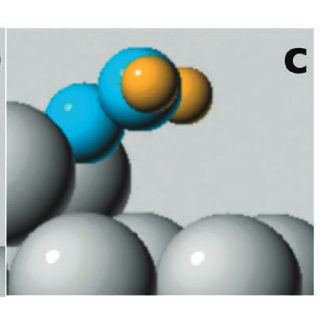


NNH2 from Phys. Chem. Chem. Phys. 14, 1235–1245 (2012)

In [237]:
# X=N-N=H2: ""
df_XNNH = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="BL:BN", skiprows=1, nrows=22)
bo_xnnh = {'X':1, 'Xm':4, 'Xp': 0, 'Xpm': 0}
get_bes(df_XNNH, bo_xnnh)

alpha 0.6
MSE ME 0.21878491049545462
MSE Gao 0.17125795156110232


,Surfaces,DFTcal,predicted,metal,facet,cn,psi,theta,mycalc,sq_err_me,sq_err_gao
0,Ti(111),-2.11828,-1.487119,Ti,111,7.5,10.39,-3.34168,-1.89324,0.050643,0.398364
1,Fe(111),-0.16129,-0.257966,Fe,111,7.5,34.97,-2.85949,-0.41844,0.066126,0.009346
2,Cu(111),1.19355,1.177610,Cu,111,7.5,63.68,-3.22725,1.30416,0.012235,0.000254
3,Zr(111),-2.34409,-1.405096,Zr,111,7.5,12.03,-3.66589,-1.79484,0.301676,0.881710
4,Ru(111),0.17742,-0.552055,Ru,111,7.5,29.09,-2.16798,-0.77124,0.899956,0.532133
5,Rh(111),0.13978,-0.230284,Rh,111,7.5,35.53,-2.59202,-0.38484,0.275226,0.136947
6,Pd(111),0.65412,0.266128,Pd,111,7.5,45.45,-2.67288,0.21036,0.196923,0.150538
7,Ag(111),2.09677,2.348285,Ag,111,7.5,87.10,-3.72923,2.70936,0.375267,0.063260
8,Re(111),-1.06452,-0.717127,Re,111,7.5,25.79,-3.21192,-0.96924,0.009078,0.120682
9,Os(111),-0.07348,-0.552055,Os,111,7.5,29.09,-2.41888,-0.77124,0.486869,0.229034


In [253]:
# XNH2: "BQ:BS"
df_XNH2 = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="BQ:BS", skiprows=1, nrows=34)
bo_xnh2 = {'X':2, 'Xm':4, 'Xp': 0, 'Xpm': 0}
df_calc = get_bes(df_XNH2, bo_xnh2)
df_calc.to_csv("XNH2.csv")

alpha 0.4
MSE ME 0.14471823461911784
MSE Gao 0.09528864719384192


In [283]:
# XNH2: "BQ:BS"
df_XNH2 = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="BQ:BS", skiprows=1, nrows=34)
bo_xnh2 = {'X':2, 'Xm':4, 'Xp': 0, 'Xpm': 0}
get_bes(df_XNH2, bo_xnh2)

{'111': 7.5, '100': 6.62, '211': 5.5, 'PtM@111': 2.5}
alpha 0.4
0     111
1     111
2     111
3     111
4     111
5     111
6     111
7     111
8     111
9     111
10    111
11    111
12    111
13    111
14    111
15    111
16    111
17    111
18    111
19    111
20    111
21    111
22    111
23    211
24    211
25    211
26    211
27    211
28    211
29    211
30    211
31    211
32    211
33    211
Name: facet, dtype: object
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
211
211
211
211
211
211
211
211
211
211
211
MSE ME 0.14471823461911784
MSE Gao 0.09528864719384192


,Surfaces,DFTcal,predicted,metal,facet,cn,psi,theta,mycalc,sq_err_me,sq_err_gao
0,Sc(111),-2.18378,-1.909059,Sc,111,7.5,6.62,-3.34858,-2.508755,0.105609,0.075472
1,Ti(111),-2.01436,-1.814760,Ti,111,7.5,10.39,-3.32996,-2.357955,0.118058,0.039840
2,V(111),-1.72973,-1.691064,V,111,7.5,15.34,-3.24333,-2.159955,0.185094,0.001495
3,Cr(111),-1.69189,-1.532331,Cr,111,7.5,21.69,-3.45949,-1.905955,0.045824,0.025459
4,Fe(111),-1.02973,-1.200183,Fe,111,7.5,34.97,-3.32853,-1.374755,0.119042,0.029054
5,Co(111),-0.65709,-0.997372,Co,111,7.5,43.09,-3.28069,-1.049955,0.154343,0.115792
6,Ni(111),-0.70811,-0.765599,Ni,111,7.5,52.36,-3.70251,-0.679155,0.000838,0.003305
7,Cu(111),-0.32973,-0.482395,Cu,111,7.5,63.68,-3.77693,-0.226355,0.010686,0.023307
8,Y(111),-1.98923,-1.890074,Y,111,7.5,7.38,-3.18443,-2.478355,0.239243,0.009832
9,Zr(111),-2.02693,-1.773748,Zr,111,7.5,12.03,-3.40813,-2.292355,0.070450,0.064101


In [34]:
# XF: "BQ:BS"
df_XF = pd.read_excel(gao_file, sheet_name ="Fig. 7", usecols="BW:BY", skiprows=1, nrows=33)
bo_xf = {'X':0, 'Xm':1, 'Xp': 0, 'Xpm': 0}
df_calc = get_bes(df_XF, bo_xf)
df_calc.to_csv("XF.csv")

alpha 0.5
MSE ME 4.071872101060606
MSE Gao 0.024452634561455643


In [289]:
df_XF["facet"]

0     PtM111
1     PtM111
2     PtM111
3     PtM111
4     PtM111
5     PtM111
6     PtM111
7     PtM111
8     PtM111
9     PtM111
10    PtM111
11    PtM111
12    PtM111
13    PtM111
14    PtM111
15    PtM111
16    PtM111
17    PtM111
18    PtM111
19    PtM111
20    PtM111
21    PtM111
22    PtM111
23    PtM111
24    PtM111
25    PtM111
26    PtM111
27    PtM111
28    PtM111
29    PtM111
30    PtM111
31    PtM111
32    PtM111
Name: facet, dtype: object

In [207]:
# find the values for x, xm, xp, xpm that satisfies (xm-x)/(xm+1) - (xp)/(xpm+1) = 0.3, where all x's are integers
xs = [0,1,2,3,4,5,6]
xms = [0,1,2,3,4,5,6]
xps = [0,1,2,3,4,5,6]
xpms = [0,1,2,3,4,5,6]

slope = 0.3
# get the combinations of the values
combs = list(itertools.product(xms, xs,xpms, xps))
for comb in combs:
    xm = comb[0]
    x = comb[1]
    xpm = comb[2]
    xp = comb[3]
    try:
        ans = (xm-x)/(xm+1) - (xp)/(xpm+1)
        if  np.isclose(ans, slope, atol=0.005):
            print(comb, ans)
    except ZeroDivisionError:
        pass

(1, 0, 4, 1) 0.3
(3, 1, 4, 1) 0.3
(4, 0, 1, 1) 0.30000000000000004
(4, 0, 3, 2) 0.30000000000000004
(4, 0, 5, 3) 0.30000000000000004
(5, 2, 4, 1) 0.3


In [166]:
xm = 3
x = 1
xpm = 0
xp = 0
(xm-x)/(xm+1) - (xp)/(xpm+1)

0.5